In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf

In [2]:
names = [
    'class',
    'age',
    'menopause',
    'tumor-size',
    'inv-nodes',
    'node-caps',
    'deg-malig',
    'breast',
    'breast-quad',
    'irradiat'
]

ages = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
menopause = ['lt40', 'ge40', 'premeno']
tum_size = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59']
inv_nodes = ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-23', '24-26', '27-29', '30-32', '33-35', '36-39']
breast_quad = ['left_up', 'left_low', 'right_up', 'right_low', 'central']

df = pd.read_csv('breast-cancer.data', names=names)
df['class'] = (df['class'] == 'no-recurrence-events').astype(int)
df['age'] = df['age'].apply(lambda x: ages.index(x))
df['menopause'] = df['menopause'].apply(lambda x: menopause.index(x))
df['tumor-size'] = df['tumor-size'].apply(lambda x: tum_size.index(x))
df['inv-nodes'] = df['inv-nodes'].apply(lambda x: inv_nodes.index(x))
df['node-caps'] = (df['node-caps'] == 'yes').astype(int)
df['breast'] = (df['breast'] == 'left').astype(int)
df = df[df['breast-quad'] != '?']
df['breast-quad'] = df['breast-quad'].apply(lambda x: breast_quad.index(x))
df['irradiat'] = (df['irradiat'] == 'yes').astype(int)
df.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,1,2,2,6,0,0,3,1,1,0
1,1,3,2,4,0,0,2,0,2,0
2,1,3,2,4,0,0,2,1,1,0
3,1,5,1,3,0,0,2,0,0,0
4,1,3,2,0,0,0,2,0,3,0


In [3]:
from copy import deepcopy


def get_xy(df, oversample = False): 
    df = deepcopy(df)
    X = df[df.columns[1:]].values
    y = df[df.columns[0]].values

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y) # type: ignore


    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [4]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

_, X_train, y_train = get_xy(train, oversample=True)
_, X_val, y_val = get_xy(val)
_, X_test, y_test = get_xy(test)

In [5]:
def plot_history(history, loss_fn_name='Binary crossentropy'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(loss_fn_name)
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.legend()

    plt.show()

KNN model

In [114]:
knn_model = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', p=1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', p=1)

In [115]:
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.59      0.51        17
           1       0.80      0.70      0.75        40

    accuracy                           0.67        57
   macro avg       0.63      0.64      0.63        57
weighted avg       0.70      0.67      0.68        57



Naive Bayes

In [116]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.53      0.56        17
           1       0.81      0.85      0.83        40

    accuracy                           0.75        57
   macro avg       0.70      0.69      0.70        57
weighted avg       0.75      0.75      0.75        57



Support Vector Machine

In [118]:
svc_model = SVC(C=128, kernel='linear')
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.53      0.47        17
           1       0.78      0.70      0.74        40

    accuracy                           0.65        57
   macro avg       0.60      0.61      0.61        57
weighted avg       0.67      0.65      0.66        57



Neural Net

In [148]:
def train(X_train, y_train, num_nodes, activation_f, dropout, lr, batch_size, epochs, loss, layers_num=1):
    layers = []
    for _ in range(layers_num):
        layers.append(tf.keras.layers.Dense(num_nodes, activation=activation_f))
        layers.append(tf.keras.layers.Dropout(dropout))
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation=activation_f, input_shape=(9,)),
        tf.keras.layers.Dropout(dropout),
        *layers,
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=loss, metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        verbose=0 # type: ignore
                        )
    
    return model, history

In [160]:
least_val_loss = float('inf')
least_loss_model = None
best_model_params = ''

for nn in [32, 64, 128]:
    for dropout in [0, 0.1, 0.2]:
        for lr in [0.01, 0.005, 0.001]:
            for batch_size in [64, 128]:
                for epochs in [50, 150]:
                    model, history = train(X_train, y_train, nn, 'relu', dropout, lr, batch_size, epochs, 'binary_crossentropy', 1)

                    # plot_history(history)
                    # print(f'nn: {nn}, act_f: relu, dropout: {dropout}, lr: {lr}, batch_size: {batch_size}, epochs: {epochs}, loss: binary_crossentropy, layers_num: 1')

                    val_loss = model.evaluate(X_val, y_val)[0]

                    if val_loss < least_val_loss:
                        least_val_loss = val_loss
                        least_loss_model = model
                        best_model_params = f'nn: {nn}, act_f: relu, dropout: {dropout}, lr: {lr}, batch_size: {batch_size}, epochs: {epochs}, loss: binary_crossentropy, layers_num: 1'

2/2 [==============================] - 0s 6ms/step - loss: 0.8552 - accuracy: 0.5614


In [161]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
print(best_model_params)
print(classification_report(y_test, y_pred))

2/2 [==============================] - 0s 4ms/step
nn: 32, act_f: relu, dropout: 0.2, lr: 0.001, batch_size: 128, epochs: 50, loss: binary_crossentropy, layers_num: 1
              precision    recall  f1-score   support

           0       0.36      0.67      0.47        15
           1       0.83      0.57      0.68        42

    accuracy                           0.60        57
   macro avg       0.59      0.62      0.57        57
weighted avg       0.70      0.60      0.62        57



Wrong methods but did it for general purpose

In [ ]:
import seaborn as sns

# for i in range(len(names)-1):
#     for j in range(i+1, len(names)-1):
#         x_label = names[i]
#         y_label = names[j]
#         sns.scatterplot(x=x_label, y=y_label, data=df, hue='class')
#         plt.show()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[]

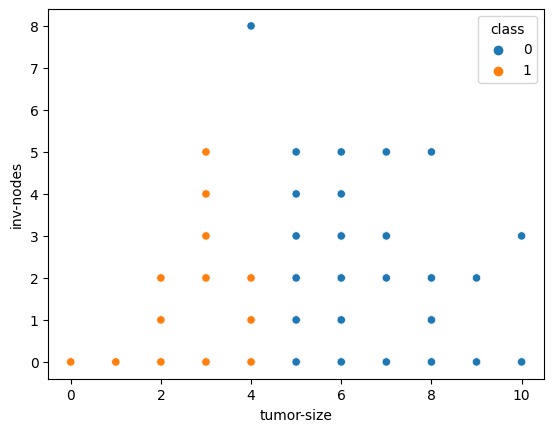

In [14]:
x1 = 'tumor-size'
x2 = 'inv-nodes'
X = df[[x1, x2]].values
kmeans = KMeans(n_clusters=2).fit(X)
clusters = kmeans.labels_
clusters_df = pd.DataFrame(np.hstack((X, clusters.reshape(-1, 1))), columns=[x1, x2, 'class'])

sns.scatterplot(x='tumor-size', y='inv-nodes', hue='class', data=clusters_df)
plt.plot()


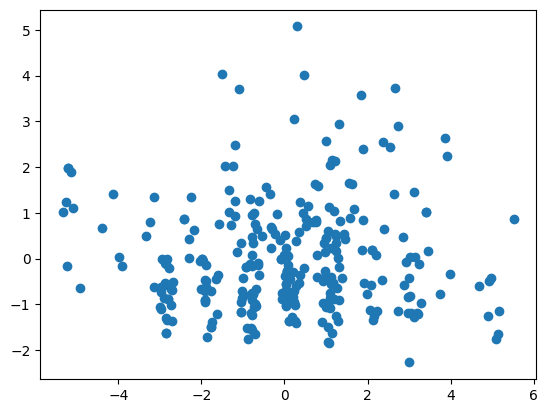

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = df[df.columns[1:]].values
transformed_x = pca.fit_transform(X)
plt.scatter(transformed_x[:,0], transformed_x[:,1])

In [20]:
kmeans_pca_df = pd.DataFrame(
    np.hstack((transformed_x,
               kmeans.labels_.reshape(-1, 1)
               )), columns=['pca1', 'pca2', 'class'])

truth_pca_df = pd.DataFrame(
    np.hstack((transformed_x,
               df['class'].values.reshape(-1, 1)
               )), columns=['pca1', 'pca2', 'class'])

[]

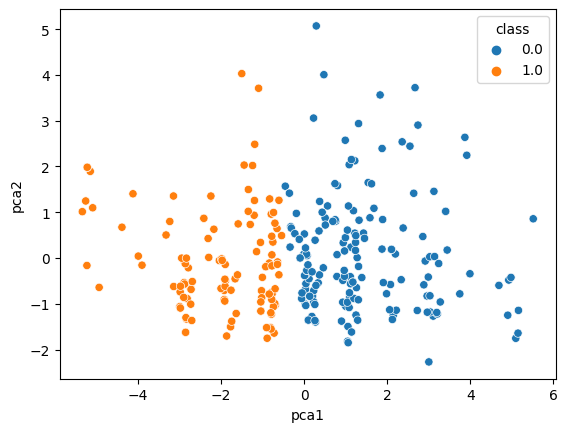

In [21]:
sns.scatterplot(x='pca1', y='pca2', hue='class', data=kmeans_pca_df)
plt.plot()

[]

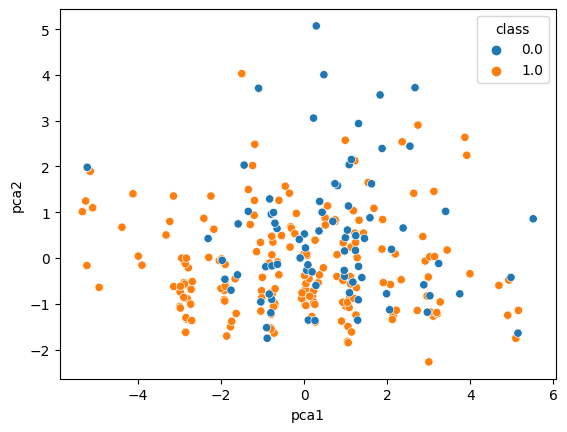

In [22]:
sns.scatterplot(x='pca1', y='pca2', hue='class', data=truth_pca_df)
plt.plot()